# 1. Initalization

In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

project_root = Path.cwd().resolve().parent
data_dir = project_root / "data"

# Import MSTR
mstr = pd.read_csv(
    "../data/MSTR.csv",
    header=2,
    parse_dates=["Date"],
    date_format="%Y-%m-%d",
    index_col="Date"
)

mstr.columns = ["Close", "High", "Low", "Open", "Volume"]
mstr.sort_index(inplace=True)
mstr.index = pd.to_datetime(mstr.index)


# Import BTC-USD
btc = pd.read_csv(
    "../data/BTC-USD.csv",
    header=2,
    parse_dates=["Date"],
    date_format="%Y-%m-%d",
    index_col="Date"
)

btc.columns = ["Close", "High", "Low", "Open", "Volume"]
btc.sort_index(inplace=True)
btc.index = pd.to_datetime(btc.index)
btc = btc.reindex(mstr.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-08-13 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1826 non-null   float64
 1   High    1826 non-null   float64
 2   Low     1826 non-null   float64
 3   Open    1826 non-null   float64
 4   Volume  1826 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


<Axes: xlabel='Date'>

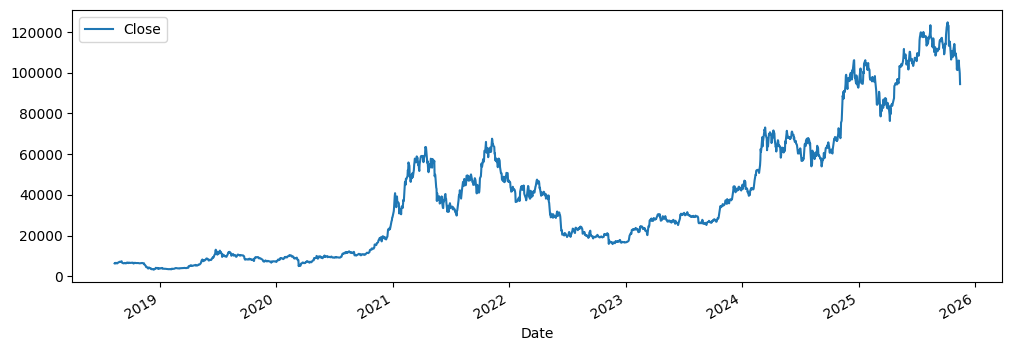

In [28]:
btc.info()
btc.describe()
btc.isna().sum()
btc.plot(y="Close", figsize=(12,4))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2018-08-13 to 2025-11-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1826 non-null   float64
 1   High    1826 non-null   float64
 2   Low     1826 non-null   float64
 3   Open    1826 non-null   float64
 4   Volume  1826 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


<Axes: xlabel='Date'>

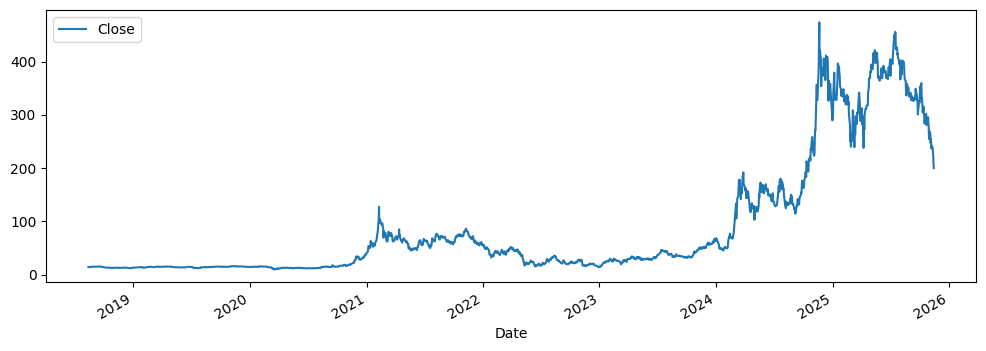

In [29]:
mstr.info()
mstr.describe()
mstr.isna().sum()
mstr.plot(y="Close", figsize=(12,4))

<Axes: title={'center': 'BTC Close vs EMA21 vs Quarterly VWAP'}, xlabel='Date'>

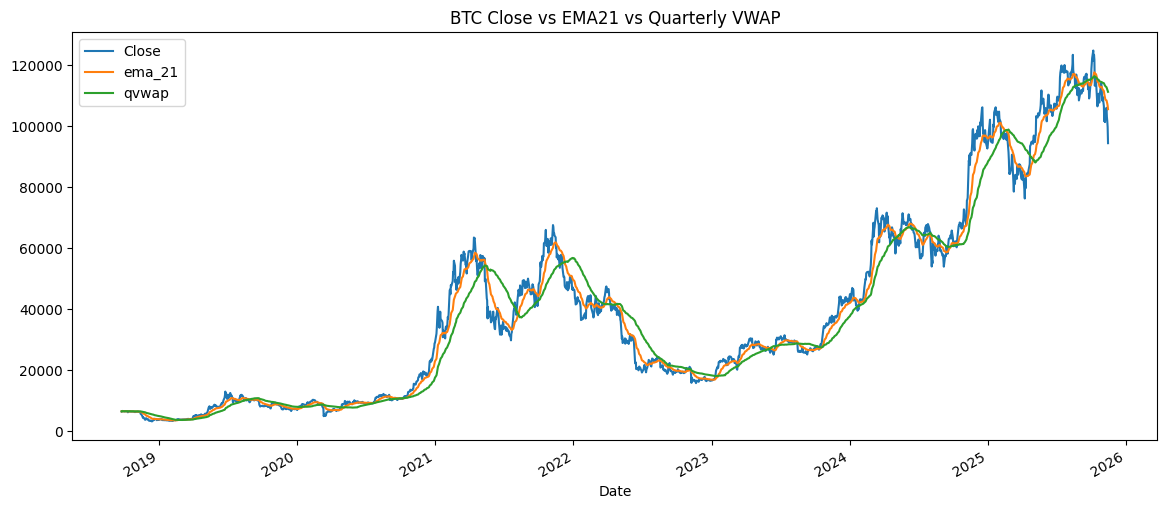

In [43]:
# Bitcoin
btc["log_ret"] = np.log(btc["Close"]).diff()

# EMA 21
btc["ema_21"] = btc["Close"].ewm(span=21).mean()

# Quarterly VWAP
btc["qvwap"] = (
    (btc["Close"] * btc["Volume"]).rolling("90D").sum()
    / btc["Volume"].rolling("90D").sum()
)

# Standarized log return
window=30
rolling_mean = btc["log_ret"].rolling(window).mean()
rolling_std = btc["log_ret"].rolling(window).std()
btc["z_log_ret"] = (btc["log_ret"]-rolling_mean)/rolling_std
btc.dropna(inplace=True)

btc[["Close", "ema_21", "qvwap"]].plot(
    figsize=(14,6),
    title="BTC Close vs EMA21 vs Quarterly VWAP"
)

<Axes: title={'center': 'BTC Standardized Log-Returns (30-Day Window)'}, xlabel='Date'>

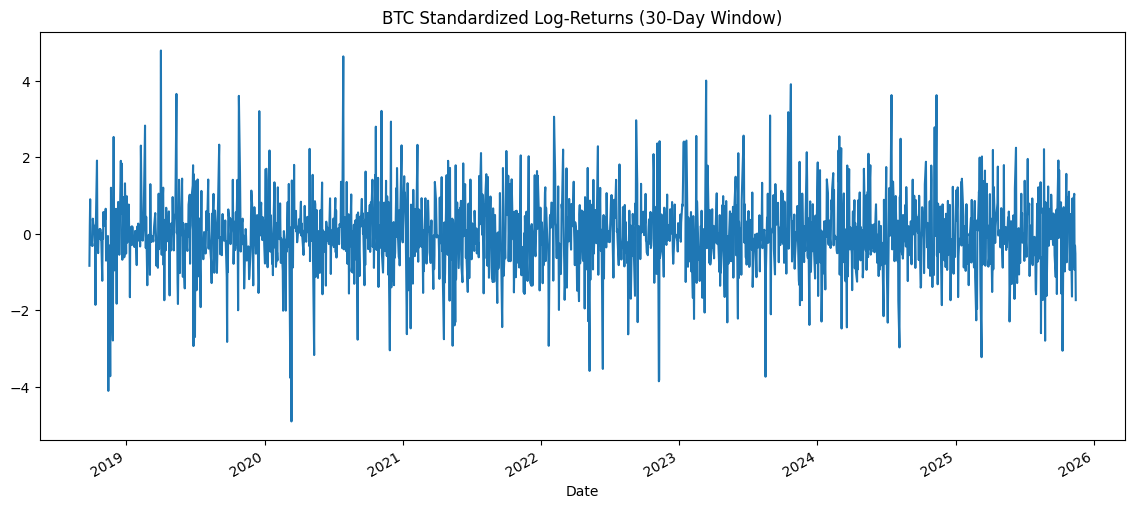

In [44]:
btc["z_log_ret"].plot(
    figsize=(14,6),
    title="BTC Standardized Log-Returns (30-Day Window)"
)

<Axes: >

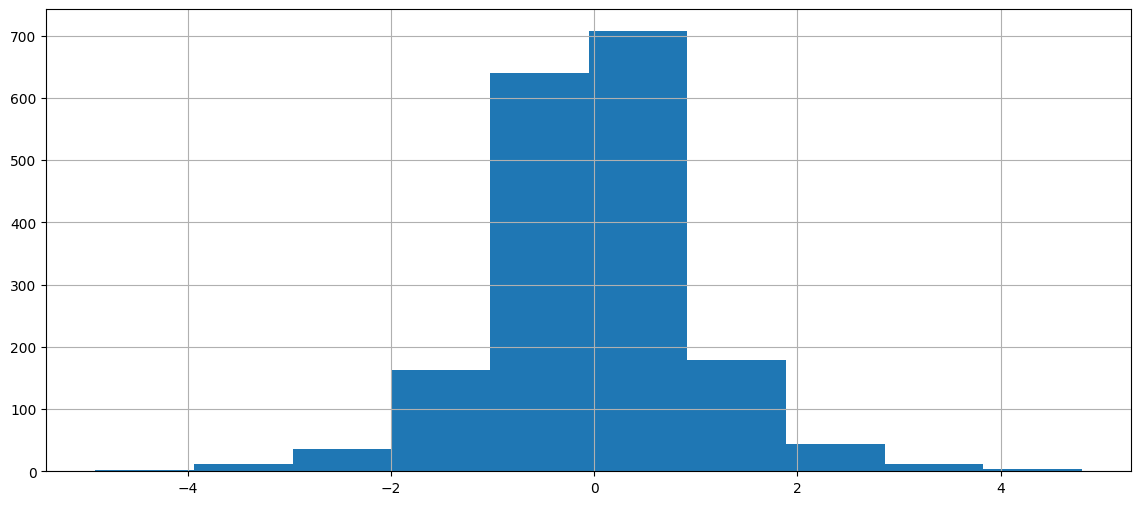

In [45]:
btc["z_log_ret"].hist(figsize=(14, 6))

<Axes: title={'center': 'MSTR Close vs EMA21 vs Quarterly VWAP'}, xlabel='Date'>

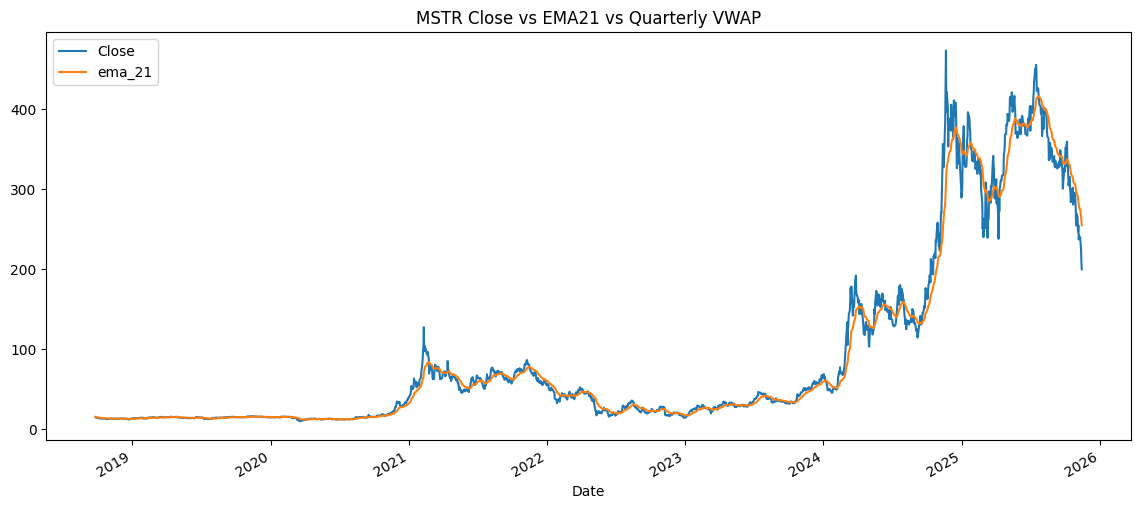

In [47]:
# MSTR
mstr["log_ret"] = np.log(mstr["Close"]).diff()

# EMA 21
mstr["ema_21"] = mstr["Close"].ewm(span=21).mean()

# Quarterly VWAP
# mstr["qvwap"] = (
#     (mstr["Close"] * mstr["Volume"]).rolling("90D").sum()
#     / mstr["Volume"].rolling("90D").sum()
# )

# Standarized log return
window=30
rolling_mean = mstr["log_ret"].rolling(window).mean()
rolling_std = mstr["log_ret"].rolling(window).std()
mstr["z_log_ret"] = (mstr["log_ret"]-rolling_mean)/rolling_std
mstr.dropna(inplace=True)

mstr[["Close", "ema_21"]].plot(
    figsize=(14,6),
    title="MSTR Close vs EMA21 vs Quarterly VWAP"
)


<Axes: title={'center': 'MSTR Standardized Log-Returns (30-Day Window)'}, xlabel='Date'>

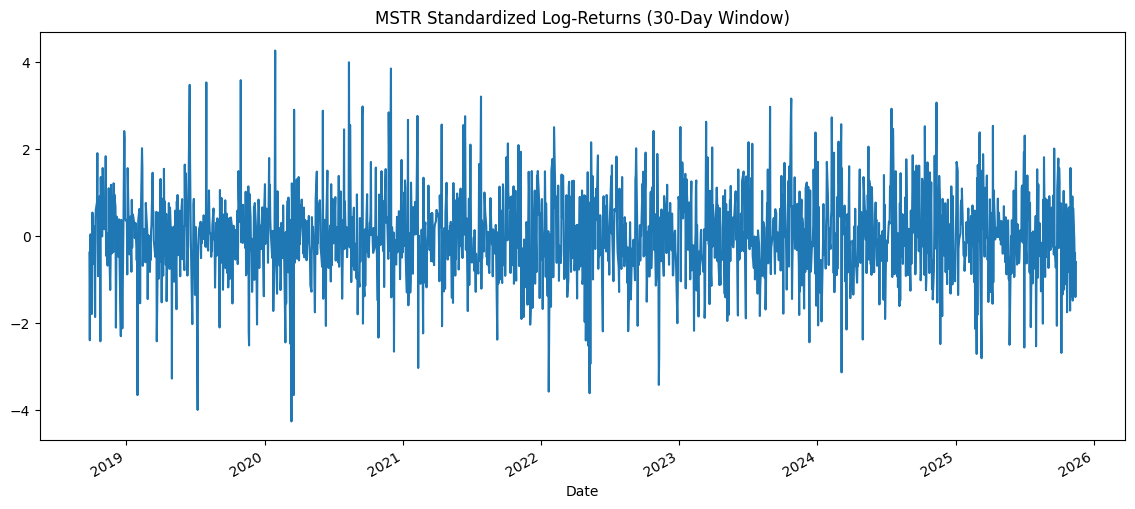

In [48]:
mstr["z_log_ret"].plot(
    figsize=(14,6),
    title="MSTR Standardized Log-Returns (30-Day Window)"
)

<Axes: >

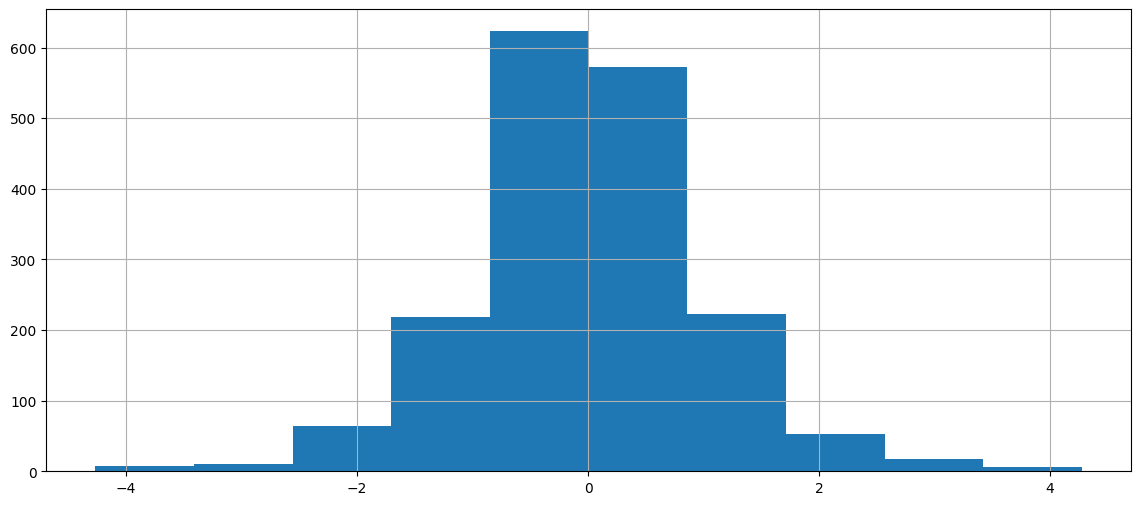

In [49]:
mstr["z_log_ret"].hist(figsize=(14, 6))

# 2. Correlation?

In [50]:
print(btc.index.dtype, btc.index[:3])
print(mstr.index.dtype, mstr.index[:3])


datetime64[ns] DatetimeIndex(['2018-09-25', '2018-09-26', '2018-09-27'], dtype='datetime64[ns]', name='Date', freq=None)
datetime64[ns] DatetimeIndex(['2018-09-25', '2018-09-26', '2018-09-27'], dtype='datetime64[ns]', name='Date', freq=None)


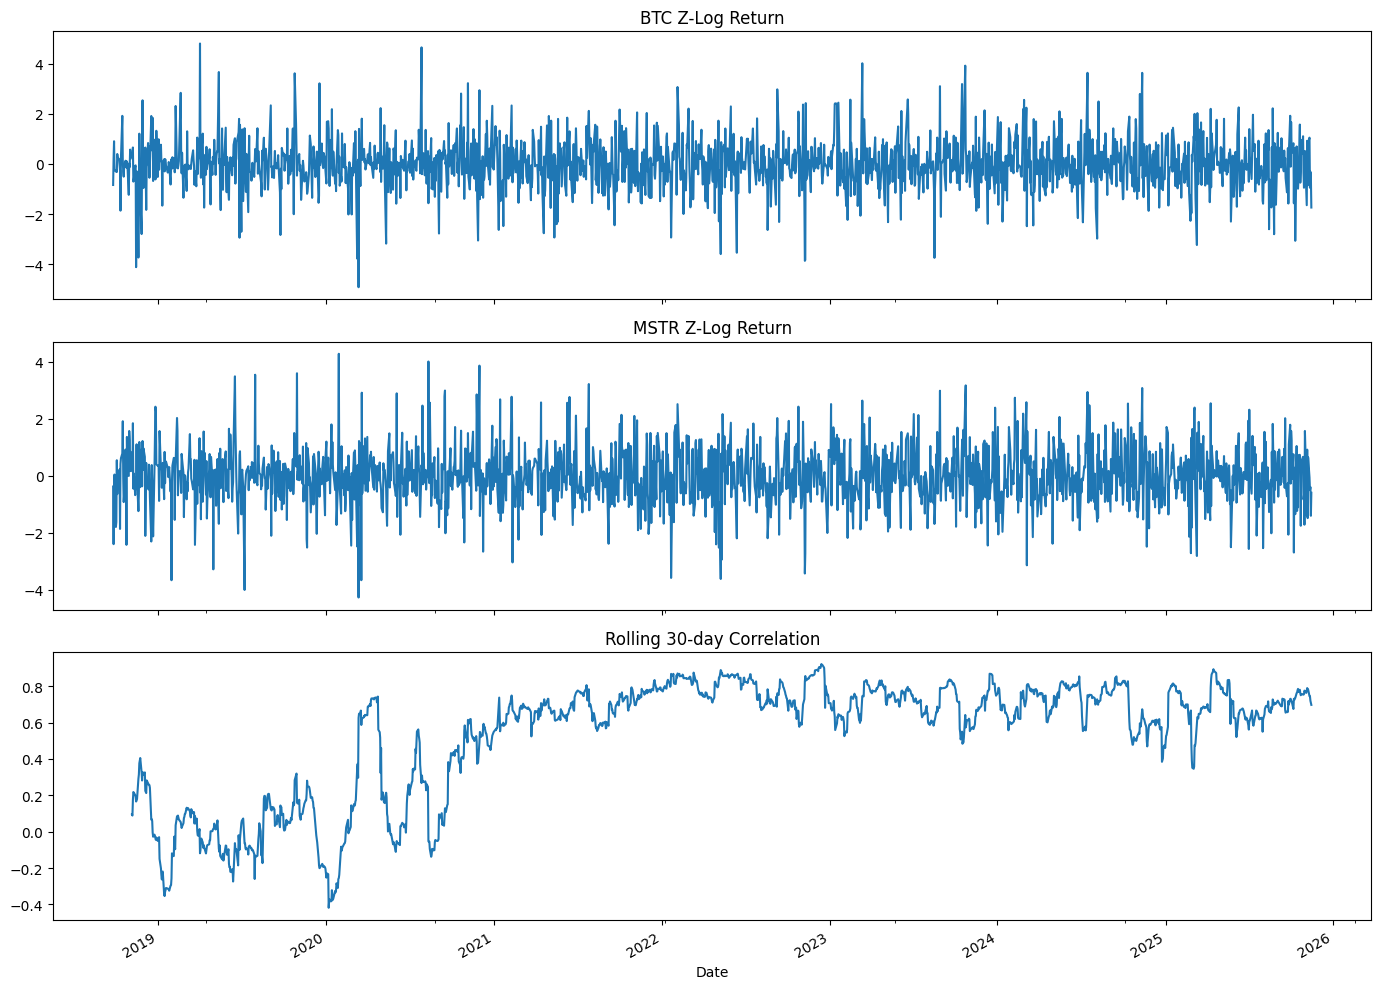

In [51]:
# 30 day rolling correlation between assets
corr = btc["z_log_ret"].rolling(30).corr(mstr["z_log_ret"])

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

btc["z_log_ret"].plot(ax=axs[0], title="BTC Z-Log Return")
mstr["z_log_ret"].plot(ax=axs[1], title="MSTR Z-Log Return")
corr.plot(ax=axs[2], title="Rolling 30-day Correlation")

plt.tight_layout()


# Spread

Date
2018-09-25    0.458298
2018-09-26   -2.606522
2018-09-27   -1.304057
2018-09-28    0.272080
2018-10-01   -1.493240
                ...   
2025-11-10   -1.103313
2025-11-11    0.443608
2025-11-12   -0.085253
2025-11-13   -0.881890
2025-11-14    1.138489
Name: spread, Length: 1796, dtype: float64

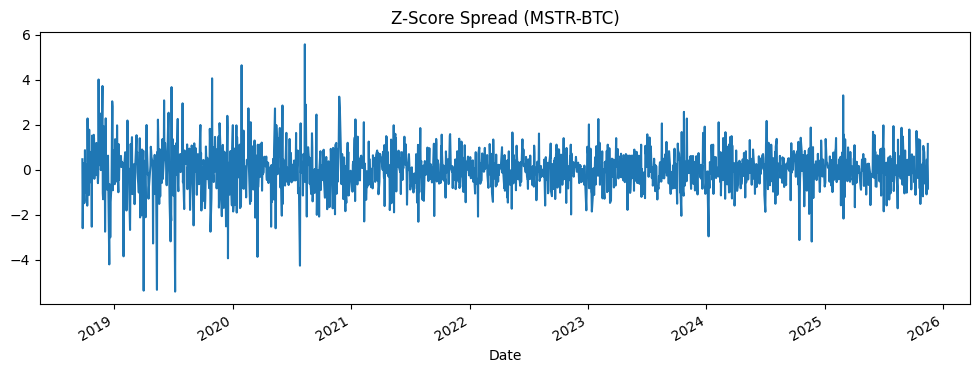

In [63]:
spread = (mstr["z_log_ret"] - btc["z_log_ret"]).rename("spread")
spread.plot(figsize=(12, 4), title="Z-Score Spread (MSTR-BTC)")
spread

# Does the spread have any predictability of forward returns of MSTR, and is this convex?

In [64]:
import statsmodels.api as sm#

y = mstr["log_ret"].shift(-1).rolling(5).sum()
X = sm.add_constant(spread)

model = sm.OLS(y, X, missing="drop").fit(
    cov_type="HAC",
    cov_kwds={"maxlags":5}
)

model.params


const     0.007610
spread    0.013597
dtype: float64

In [66]:

horizons = [1, 3, 5, 10, 15, 20]
results = []

# Regress spread on H-period forwarded
for H in horizons:
    if H == 1:
        y = mstr["log_ret"].shift(-1)
    else:
        y = mstr["log_ret"].shift(-1).rolling(H).sum() 
    
    X = sm.add_constant(spread)

    model = sm.OLS(y, X, missing="drop").fit(
        cov_type="HAC", 
        cov_kwds={"maxlags":5}
    )

    results.append({
        "H": H,
        "beta": model.params["spread"],
        "t": model.tvalues["spread"],
        "p": model.pvalues["spread"]
    })

pd.DataFrame(results)




,H,beta,t,p
0,1,-0.002589,-2.039414,4.140870e-02
1,3,0.014801,6.330838,2.438326e-10
2,5,0.013597,4.780382,1.749622e-06
3,10,0.011321,2.773322,5.548718e-03
4,15,0.011156,2.371108,1.773486e-02
5,20,0.009587,1.798929,7.202997e-02


The effect is very small, interesting that the beta changes sign from short-term to medium-term. Since price movements of MSTR is just 1% per 1 std deviation (in difference). Therefore, we must look at MNAV filter, regime filter, volume, and nonlinearity. OLS results shows that MSTR's future returns tend to conitnue in the diretion implied by the MSTR-BTC spread.

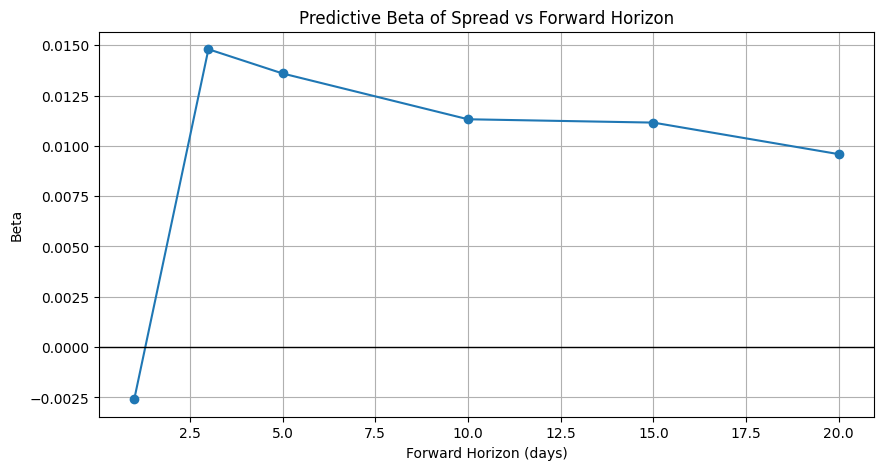

In [67]:
res = pd.DataFrame(results).sort_values("H")
res

plt.figure(figsize=(10, 5))
plt.plot(res["H"], res["beta"], marker="o")
plt.axhline(0, color="black", linewidth=1)
plt.title("Predictive Beta of Spread vs Forward Horizon")
plt.xlabel("Forward Horizon (days)")
plt.ylabel("Beta")
plt.grid(True)
plt.show()


In [71]:
spread_sq = (spread ** 2).rename("spread_sq")
results = []

# Regress spread on H-period forwarded
for H in horizons:
    if H == 1:
        y = mstr["log_ret"].shift(-1)
    else:
        y = mstr["log_ret"].shift(-1).rolling(H).sum() 
    
    X = pd.concat([spread, spread_sq], axis=1)
    X = sm.add_constant(X)

    model = sm.OLS(y, X, missing="drop").fit(
        cov_type="HAC", 
        cov_kwds={"maxlags":5}
    )

    results.append({
        "H": H,
        "b1": model.params["spread"],
        "b2": model.params["spread_sq"],
        "t_b1": model.tvalues["spread"],
        "t_b2": model.tvalues["spread_sq"],
        "p_b1": model.pvalues["spread"],
        "p_b2": model.pvalues["spread_sq"]
    })

pd.DataFrame(results)

,H,b1,b2,t_b1,t_b2,p_b1,p_b2
0,1,-0.002554,0.000215,-1.992261,0.510740,4.634247e-02,0.609533
1,3,0.014928,0.000814,6.292175,1.013850,3.130475e-10,0.310654
2,5,0.013602,0.000029,4.684966,0.027389,2.800058e-06,0.978149
3,10,0.011340,0.000123,2.727610,0.078603,6.379491e-03,0.937348
4,15,0.011256,0.000630,2.349932,0.345128,1.877686e-02,0.729998
5,20,0.009739,0.000940,1.792849,0.433799,7.299705e-02,0.664434
